In [182]:
import numpy as np

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

import time

import sys

from brian2 import *

## Neuron Type Definitions

## 4th order Runge-Kutta

In [13]:
class WilsonRK4(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonRK4, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
        # TODO(arvoelke): Try replacing this solver with something like
        # http://www2.gsu.edu/~matrhc/PyDSTool.htm
        # The main consideration is that we need a callback to count spikes
        from scipy.integrate import ode
        self.solver = ode(self._ode_fun).set_integrator(
            'dopri5', first_step=0.00005, nsteps=100,
            rtol=1e-2, atol=1e-3)  # runge-kutta method of order (4)5
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance],
            dt=0.001, settle_time=0.1, sim_time=1.0)

    def _ode_fun(self, dummy_t, y, J):  # first argument to scipy.integrate.ode
        V, R, H = np.split(y, 3)
        dV = (-(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) -
              26*R*(V + 0.95) - 13*H*(V + 0.95) + J)
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        return np.concatenate((
            dV / self.tau_V, dR / self.tau_R, dH / self.tau_H))

    def step_math(self, dt, J, spiked, V, R, H):
        # It's a little silly to be reinitializing the solver on
        # every time-step, but any other ways that I could think of would 
        # violate the nengo builder's assumption that the neuron's state is
        # encapsulated by the signals in SimNeurons
        self.solver.set_initial_value(np.concatenate((V, R, H)))
        self.solver.set_f_params(J.clip(max=self._maxJ))
        
        spiked[:] = 0
        AP = V > self.threshold
        def spike_detector(dummy_t, y):  # callback for each sub-step
            V_t = y[:len(V)] > self.threshold
            spiked[:] += V_t & (~AP)  # note the "+="
            AP[:] = V_t
        self.solver.set_solout(spike_detector)

        V[:], R[:], H[:] = np.split(self.solver.integrate(self.solver.t + dt), 3)
        if not self.solver.successful():
            raise ValueError("ODE solver failed with status code: %d" % (
                self.solver.get_return_code()))
        spiked[:] /= dt

        return spiked, V, R, H


@Builder.register(WilsonRK4)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['recovery'],
                model.sig[neurons]['conductance']]))

## Euler

In [199]:
class WilsonEuler(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonEuler, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args


    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

        J_steps = 201  # Odd number so that 0 is a sample
        max_rate = max_rates.max()

        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0
        for _ in range(10):
            J = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
#             print('J', J, 'euler rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain

        return gain, bias

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)
        AP = np.zeros_like(J, dtype=bool)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance, AP],
            dt=0.00005, settle_time=0.1, sim_time=1.0)


    def step_math(self, dt, J, spiked, V, R, H, AP):
        if np.abs(J).any() >= 2.0:
            warnings.warn("input current exceeds failure point; clipping")
            J = J.clip(max=self._maxJ)

        dV = -(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) - 26*R*(V + 0.95) - 13*H*(V + 0.95) + J
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        
        V[:] = (V + dV * dt/self.tau_V).clip(-0.9, 0.3)
        R[:] = (R + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        H[:] = (H + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (V > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = V > self.threshold
        
        return spiked, V, R, H, AP


@Builder.register(WilsonEuler)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

## Brian

In [198]:
BrianLogger.suppress_name('resolution_conflict')

class WilsonBrian(NeuronType):
    
    probeable = ('spikes', 'voltage', 'recovery', 'conductance')
    tauv = NumberParam('tauv')
    taur = NumberParam('taur')
    tauc = NumberParam('tauc')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown

    def __init__(self, dt_brian=0.00005, ode='euler', thr=-0.20, tauv=0.00097, taur=0.0056, tauc=0.0990):
        super(WilsonBrian, self).__init__()
        self.dt_brian = dt_brian
        self.ode = ode
        self.thr = thr
        self.tauv = tauv
        self.taur = taur
        self.tauc = tauc
        self.namespace = {'tauv': self.tauv, 'taur': self.taur, 'tauc': self.tauc, 'thr': self.thr}

        self.eqns = '''
        # v = clip(v, -0.9, 0.3) : 1
        dv/dt = Hz/tauv * (-(17.81 + 47.58*v + 33.80*v*v)*(v - 0.48)
            - 26*r*(v + 0.95) - 13*c*(v + 0.95) + J) : 1
        dr/dt = Hz/taur * (-r + 1.29*v + 0.79 + 3.30*(v + 0.38)*(v + 0.38)) : 1
        dc/dt = Hz/tauc * (-c + 11*(v + 0.754)*(v + 0.69)) : 1
        J : 1
        '''
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("tauv", 0.00097)
        add("taur", 0.0056)
        add("tauh", 0.0990)
        return args
        
    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

        J_steps = 101  # Odd number so that 0 is a sample
        max_rate = max_rates.max()

        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0
        for _ in range(10):
            J_test = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J_test, np.ones(J_steps), np.zeros(J_steps))
#             print('J', J_test, 'brian rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J_test[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J_test[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain

        return gain, bias

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J_test = self.current(x, gain, bias)
        brianens = NeuronGroup(J_test.shape[0], self.eqns,
            threshold='v > thr', namespace=self.namespace, method=self.ode, refractory=5*ms)
        brianens.v = self._v0*np.ones_like(J_test)
        brianens.r = self._r0*np.ones_like(J_test)
        brianens.c = np.zeros_like(J_test)
        brianmon_v = StateMonitor(brianens, 'v', record=True)
        brianmon_s = SpikeMonitor(brianens, record=True)
        briannet = Network(brianens, brianmon_v, brianmon_s)
        defaultclock.dt = self.dt_brian*second
        
        # reimplement settled_firingrate()
        settle_time = 0.1
        sim_time = 1.0
        dt = 0.001  # dt_nengo
        settle_steps = int(settle_time / dt)
        sim_steps = int(sim_time / dt)
        spiked = np.zeros_like(J_test)
        voltage = np.array(brianens.v)
        all_spikes = np.zeros_like(J_test)
        print("running transients...")
        for t in range(settle_steps):
            v, s = self.step_math(J_test, briannet, brianens, brianmon_v, brianmon_s, voltage, spiked, dt)
            sys.stdout.write("\r{:6.2f}% done...".format(100 * (t + 1) / settle_steps))
        sys.stdout.write("\n")
        print("calculating rate...")
        for t in range(sim_steps):
            v, s = self.step_math(J_test, briannet, brianens, brianmon_v, brianmon_s, voltage, spiked, dt)
            all_spikes += s*dt
            sys.stdout.write("\r{:6.2f}% done...".format(100 * (t + 1) / sim_steps))
        sys.stdout.write("\n")

        return all_spikes / sim_time
    
    def step_math(self, J, briannet, brianens, brianmon_v, brianmon_s, voltage, spiked, dt):
        spiked_before = brianmon_s.i[:]
        brianens.J = J.clip(max=_maxJ)  # drive brian neurons
        briannet.run(dt*second)  # run brian neurons
        brianens.v = brianens.v[:].clip(-0.9, 0.3)
        voltage[:] = brianens.v
        spiked = np.zeros_like(voltage)
        spiked_after = brianmon_s.i[:]
        n_spikes_new = spiked_after.shape[0] - spiked_before.shape[0]
        for s in range(n_spikes_new):
            spiked[spiked_after[-(s+1)]] = 1.0/dt
        return voltage, spiked


class SimBrianNeurons(Operator):
    def __init__(self, neuron_type, neurons, J, output, states):
        super(SimBrianNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        
        self.neurons.v = states[1].initial_value
        self.neurons.r = states[2].initial_value
        self.neurons.c = states[3].initial_value
        self.brianens = neurons
        self.brianmon_v = StateMonitor(self.brianens, 'v', record=True)
        self.brianmon_s = SpikeMonitor(self.brianens, record=True)
        self.briannet = Network(self.brianens, self.brianmon_v, self.brianmon_s)
        defaultclock.dt = self.neuron_type.dt_brian*second

    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(J, self.briannet, self.brianens, 
                self.brianmon_v, self.brianmon_s, voltage, output, dt)  # output==spiked?
        return step_nrn

    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]
    
@Builder.register(WilsonBrian)
def build_wilsonneuron(model, neuron_type, neurons):
    
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    thr = neuron_type.thr

    brianens = NeuronGroup(neurons.size_in, neuron_type.eqns,
        threshold='v > thr', namespace=neuron_type.namespace, method=neuron_type.ode, refractory=5*ms)
    
    brianop = SimBrianNeurons(
        neuron_type=neuron_type,
        neurons=brianens,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[
            model.time,
            model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance']])

    model.params[neurons] = {'briannet': brianop.briannet, 'brianens': brianop.brianens}
    model.add_op(brianop)


class TransmitSpikes(Operator):
    def __init__(self, conn, spikes, states):
        super(TransmitSpikes, self).__init__()
        self.conn = conn
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            spiked = np.where(spikes > 0)[0]
            spiketimes = time * np.ones((spiked.shape[0])) * ms
            self.conn.briansgg.set_spikes(spiked, spiketimes)
        return step

    @property
    def spikes(self):
        return self.reads[0]


@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])

    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, WilsonBrian) \
            and isinstance(conn.pre_obj, nengo.Ensemble):
        if not isinstance(conn.solver, NoSolver) and conn.solver.weights is False:
            raise BuildError("Connections to WilsonNeuorns must provide a NoSolver with weight=True"
                            " (got %s from %s to %s)" % (conn.solver, conn.pre_obj, conn.post_obj))
        #todo: check that conn_pre is emitting spikes
        briannet = model.params[conn.post_obj.neurons]['briannet']
        brianens = model.params[conn.post_obj.neurons]['brianens']
        briansgg = SpikeGeneratorGroup(conn.pre_obj.n_neurons, indices=[], times=[]*ms)  # filled in during TransmitSpikes
        transform = full_transform(conn, slice_pre=False)
        w = build_decoders(model, conn, rng, transform)[1]
        
        syn_eqn = '''
        dg/dt = -tau*g/second : 1 (clock-driven)
        I_post = g : 1 (summed)
        w : 1
        '''
        briansyn = Synapses(briansgg, brianens, namespace={'tau': conn.synapse.tau},
            model=syn_eqn, on_pre='g += w', method='rk4')  # rk4
        briansyn.connect()
        for pre in range(w.shape[0]):
            for post in range(w.shape[1]):
                briansyn.w[pre, post] = w[pre, post]
#         briansyn.w[:, :] = w['i, j']
#         briansyn.w = w.ravel()  # todo: ensure indexing is correct
        briannet.add(briansgg)
        briannet.add(briansyn)
        conn.briansgg = briansgg
        
        brianspiker = TransmitSpikes(conn, model.sig[conn.pre_obj]['out'], states=[model.time])
        model.add_op(brianspiker)

    else:
        return nengo.builder.connection.build_connection(model, conn)

WARNING    /home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)
 [py.warnings]
  % nengo_class)



## Simulation

In [16]:
def go(n_neurons, neuron_type, t, dt, sample_every=0.001, max_rates=Uniform(30, 60), seed=0):
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.sin(2*np.pi*5*t))
        x = nengo.Ensemble(n_neurons, 1, seed=seed, neuron_type=neuron_type, max_rates=max_rates)
        nengo.Connection(stim, x, synapse=None)
#         nengo.Connection(stim, x.neurons, synapse=None)
        p = nengo.Probe(x.neurons, synapse=0.1, sample_every=sample_every)
        p_s = nengo.Probe(x.neurons, 'spikes', synapse=None, sample_every=sample_every)
        p_v = nengo.Probe(x.neurons, 'voltage', synapse=None, sample_every=sample_every)
    
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)
    
    return sim.trange(sample_every=sample_every), sim.data[p], sim.data[p_s], sim.data[p_v]

## Euler

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

runtime = 7.443 s


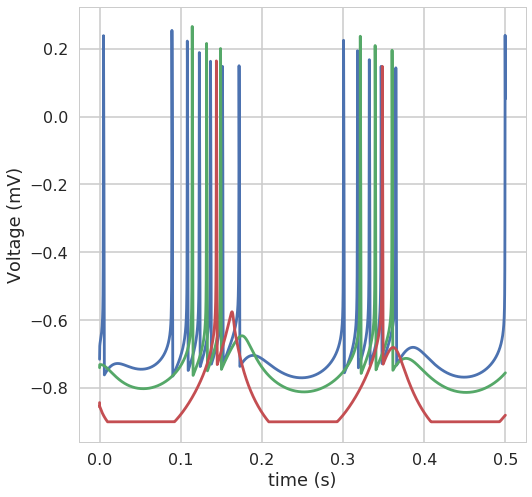

In [203]:
start = time.time()
t1, a1, s1, v1 = go(3, t=0.5, dt=0.00005, sample_every=0.00005, neuron_type=WilsonEuler())
end = time.time()
print('runtime = %.3f s' %(end-start))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, v1)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

runtime = 5.864 s


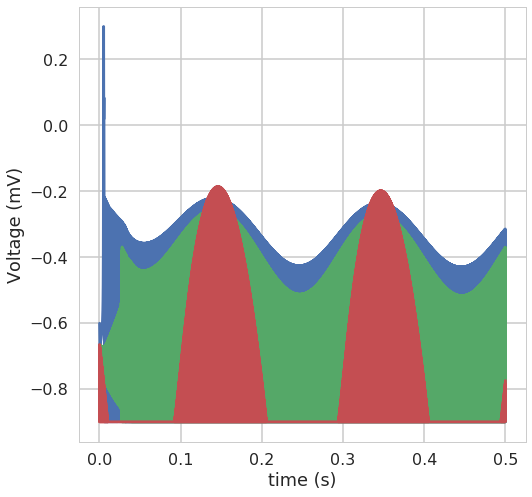

In [204]:
start = time.time()
t1, a1, s1, v1 = go(3, t=0.5, dt=0.0002, sample_every=0.0002, neuron_type=WilsonEuler())
end = time.time()
print('runtime = %.3f s' %(end-start))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, v1)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()

## RK4

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

runtime = 28.769 s


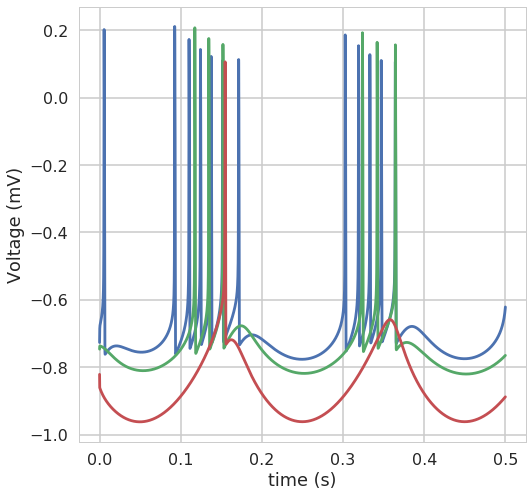

In [190]:
start = time.time()
t1, a1, s1, v1 = go(3, t=0.5, dt=0.00005, sample_every=0.00005, neuron_type=WilsonRK4())
end = time.time()
print('runtime = %.3f s' %(end-start))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, v1)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

runtime = 24.148 s


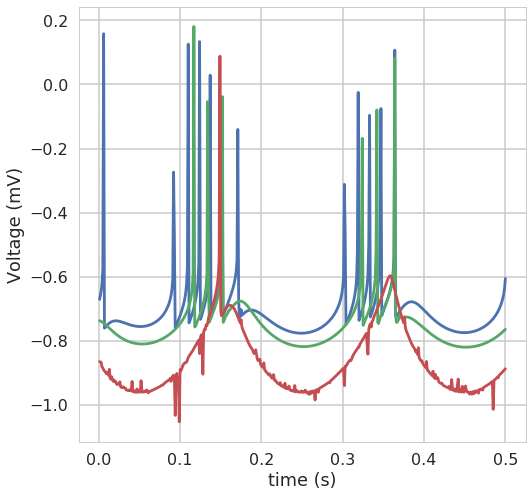

In [8]:
start = time.time()
t1, a1, s1, v1 = go(3, t=0.5, dt=0.001, sample_every=0.001, neuron_type=WilsonRK4())
end = time.time()
print('runtime = %.3f s' %(end-start))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, v1)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()

## Brian

running transients...
 74.00% done...

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

 75.00% done...

100.00% done...
calculating rate...
100.00% done...
running transients...
100.00% done...
calculating rate...
100.00% done...
running transients...
100.00% done...
calculating rate...
100.00% done...


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

runtime = 105.299 s


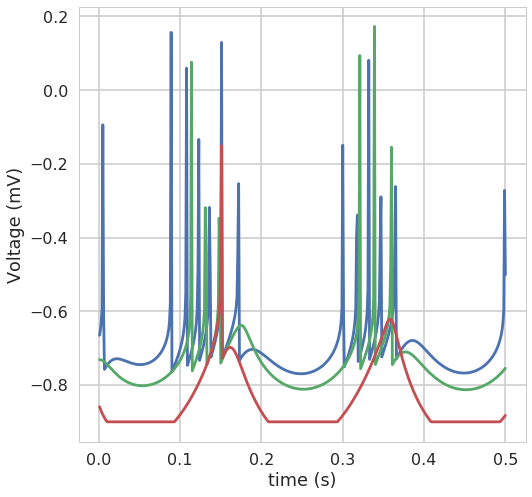

In [206]:
start = time.time()
t1, a1, s1, v1 = go(3, t=0.5, dt=0.001, sample_every=0.001, neuron_type=WilsonBrian(dt_brian=0.000025, ode='euler'))
end = time.time()
print('runtime = %.3f s' %(end-start))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, v1)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()